<a href="https://colab.research.google.com/github/jmutu001/Adversarial-Attacks-MNIST/blob/main/MNIST_Adversarial_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import **Pytorch** libraries and APIs. ss


In [ ]:
# prompt: CNN Model (cnn_model.py)

# Import **Pytorch** libraries and APIs.
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128) # Adjust input size if image size changes
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # Output layer for 10 classes

    def forward(self, x):
        # Define the forward pass
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64) # Flatten the tensor
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)

# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
            nn.Linear(7 * 7 * 16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

100%|██████████| 9912422/9912422 [00:00<00:00, 105894622.31it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99618169.26it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34103710.23it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14779308.59it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10], Step [0/235], Loss: 2.3249, Accuracy: 10.94%
Epoch [1/10], Step [150/235], Loss: 0.0957, Accuracy: 96.88%
Epoch [2/10], Step [0/235], Loss: 0.0372, Accuracy: 99.22%
Epoch [2/10], Step [150/235], Loss: 0.0282, Accuracy: 99.22%
Epoch [3/10], Step [0/235], Loss: 0.0119, Accuracy: 99.61%
Epoch [3/10], Step [150/235], Loss: 0.0297, Accuracy: 99.61%
Epoch [4/10], Step [0/235], Loss: 0.0083, Accuracy: 100.00%
Epoch [4/10], Step [150/235], Loss: 0.0152, Accuracy: 99.61%
Epoch [5/10], Step [0/235], Loss: 0.0103, Accuracy: 99.61%
Epoch [5/10], Step [150/235], Loss: 0.0132, Accuracy: 99.61%
Epoch [6/10], Step [0/235], Loss: 0.0128, Accuracy: 99.61%
Epoch [6/10], Step [150/235], Loss: 0.0050, Accuracy: 100.00%
Epoch [7/10], Step [0/235], Loss: 0.0059, Accuracy: 99.61%
Epoch [7/10], Step [150/235], Loss: 0.0113, Accuracy: 99.61%
Epoch [8/10], Step [0/235], Loss: 0.0171, Accuracy: 99.61%
Epoch [8/10], Step [150/235], Loss: 0.0013, Accuracy: 100.00%
Epoch [9/10], Step [0/235], Loss: 0.0

# **Adversarial Example**
Question: Can we fool this model?



Accuracy of the model on the 10000 test images: 24.27 %


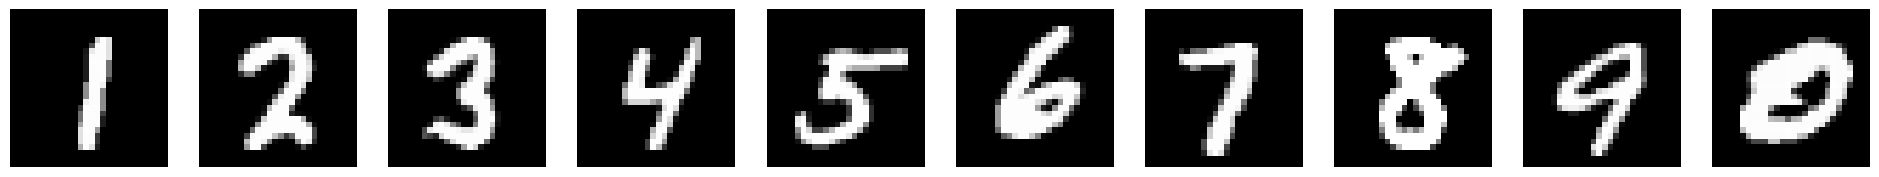

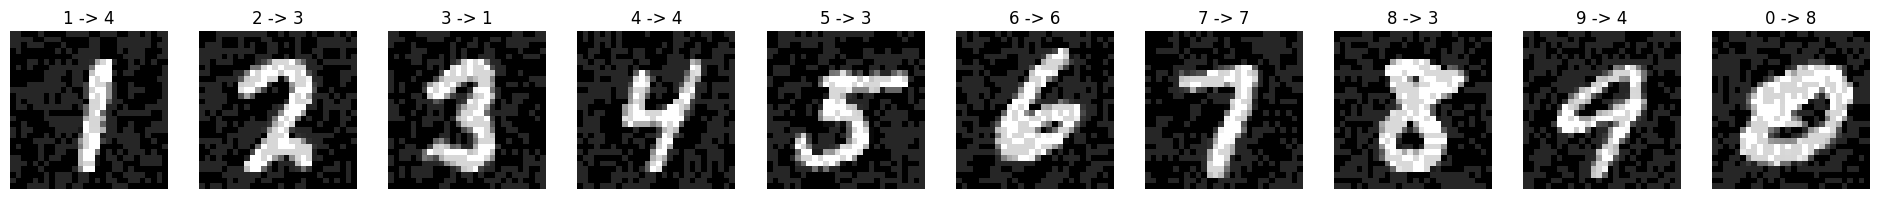

In [ ]:
#FGSM
def fgsm(model, criterion, images, labels, step_size) :

    images.requires_grad = True # give me those gradients!

    outputs = model(images) #feed the original images to the model, and get the predictions

    model.zero_grad() #zero out the gradients
    loss = criterion(outputs, labels) # compute loss value
    loss.backward() # feedback to the model, compute the gradients.

    ae_images = images + step_size*images.grad.sign()
    ae_images = torch.clamp(ae_images, 0, 1)

    return ae_images

model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = fgsm(model, criterion, images, labels, step_size=0.15)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
# show_images(ae_images[:10].detach())
show_images_withPred(ae_images[:10].detach(),labels[:10], outputs[:10].argmax(dim=1))


Accuracy of the model on the 10000 test images: 86.02 %


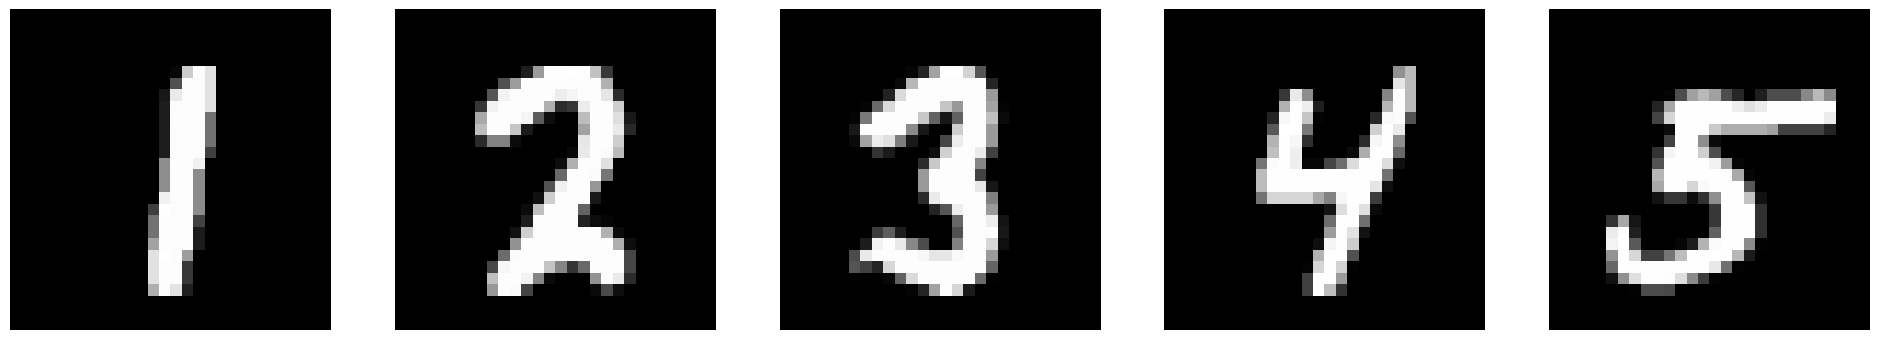

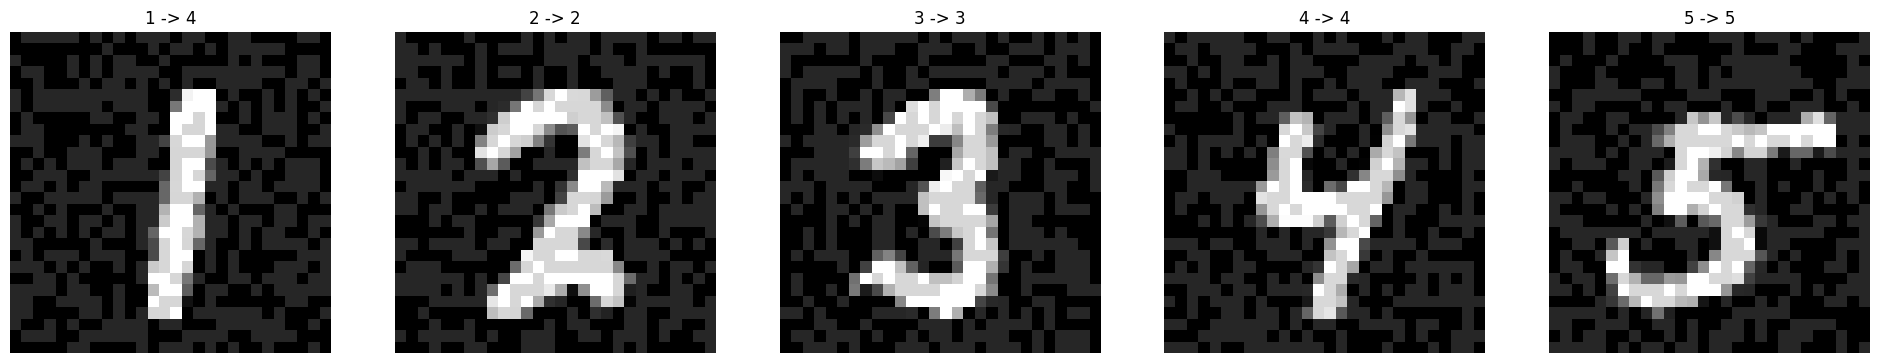

In [ ]:
#Random noise injection
def rand_noise_attack(images, step_size) :
    rand_perturbation = torch.randn_like(images)
    ae_images = images + step_size*rand_perturbation.sign()
    #show_images(rand_perturbation.sign()[:5])
    ae_images = torch.clamp(ae_images, 0, 1)

    return ae_images



model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = rand_noise_attack(images,step_size=0.15)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))



show_images(images[:5].detach())
show_images_withPred(ae_images[:5].detach(),labels[:5], outputs[:5].argmax(dim=1))

Accuracy of the model on the 10000 test images: 0.19 %


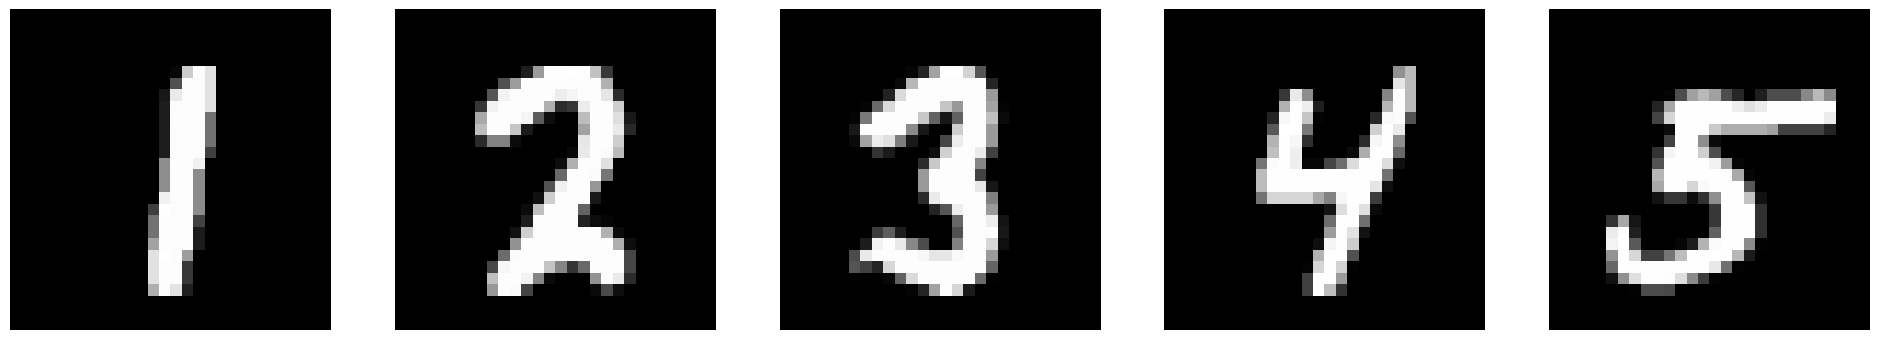

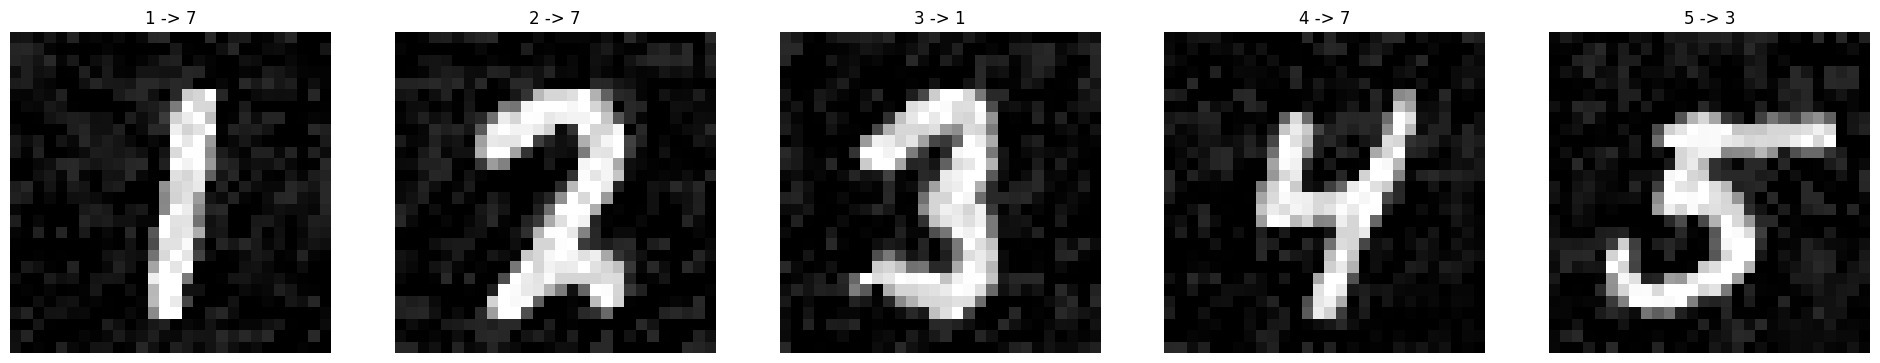

In [ ]:
# PGD Attack

def pgd_attack(model, images, criterion, labels, eps=0.3, step_size=0.004, iters=40) :
    images = images.cuda()
    labels = labels.cuda()

    ori_images = images.data

    for i in range(iters) :
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = criterion(outputs, labels)
        cost.backward()

        adv_images = images + step_size*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images


model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = pgd_attack(model, images, criterion,labels)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:5].detach())
show_images_withPred(ae_images[:5].detach(),labels[:5], outputs[:5].argmax(dim=1))

# **Black-box vs White-box AE**

White-box: the attacker has the access to the victim model, including model architecture, weights, gradients, etc.

Black-box: However, in practice, attackers usually do not have such access. Then, as an endless cat&mouse game, what should the attacker do to fool the target model?

Answer: they may train a substitute model B similar to the target model A. Then, they generate AEs on the local model B and feed the AEs to model A. If B and A are similar enough, the generated AEs should yield a high attack success rate.



In [ ]:
# Model B, ideal case, the attacker has the knowledge of the model A's architecture.

class Attacker_Model(nn.Module):
    def __init__(self):
        super(Attacker_Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model_B=Attacker_Model()
model_B.cuda()
model_B.train()


# Assume the attacker has a smaller dataset (5000 images).
from torch.utils.data import Subset

tempid = torch.range(0, 5000,dtype=torch.int)
train_dataset_attacker = Subset(train_dataset, tempid)
# Data loader
train_loader_attacker = DataLoader(dataset=train_dataset_attacker, batch_size=batch_size, num_workers=4, shuffle=True)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_attacker = torch.optim.Adam(model_B.parameters(), lr=learning_rate)


# Train model B
model_B.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader_attacker)

for epoch in range(40):
  for i, (images, labels) in enumerate(train_loader_attacker):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model_B(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer_attacker.zero_grad()
    loss.backward()
    optimizer_attacker.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model_B.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model_B(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct / total) * 100))

<ipython-input-8-70fe4467452c>:34: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  tempid = torch.range(0, 5000,dtype=torch.int)


Epoch [1/10], Step [0/20], Loss: 2.3034, Accuracy: 9.38%
Epoch [2/10], Step [0/20], Loss: 1.1538, Accuracy: 70.70%
Epoch [3/10], Step [0/20], Loss: 0.5758, Accuracy: 86.72%
Epoch [4/10], Step [0/20], Loss: 0.4192, Accuracy: 86.33%
Epoch [5/10], Step [0/20], Loss: 0.2275, Accuracy: 93.36%
Epoch [6/10], Step [0/20], Loss: 0.2319, Accuracy: 93.36%
Epoch [7/10], Step [0/20], Loss: 0.3120, Accuracy: 90.23%
Epoch [8/10], Step [0/20], Loss: 0.2010, Accuracy: 93.75%
Epoch [9/10], Step [0/20], Loss: 0.1191, Accuracy: 96.88%
Epoch [10/10], Step [0/20], Loss: 0.1615, Accuracy: 95.31%
Epoch [11/10], Step [0/20], Loss: 0.1337, Accuracy: 95.31%
Epoch [12/10], Step [0/20], Loss: 0.0599, Accuracy: 99.22%
Epoch [13/10], Step [0/20], Loss: 0.1038, Accuracy: 97.66%
Epoch [14/10], Step [0/20], Loss: 0.0927, Accuracy: 96.88%
Epoch [15/10], Step [0/20], Loss: 0.0588, Accuracy: 98.44%
Epoch [16/10], Step [0/20], Loss: 0.0529, Accuracy: 98.44%
Epoch [17/10], Step [0/20], Loss: 0.0712, Accuracy: 97.27%
Epoch [

**Now we generate the AE on model B and test them on model A**

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the model_B on the 10000 test images: 19.3 %
Accuracy of the model on the 10000 test images: 74.0 %


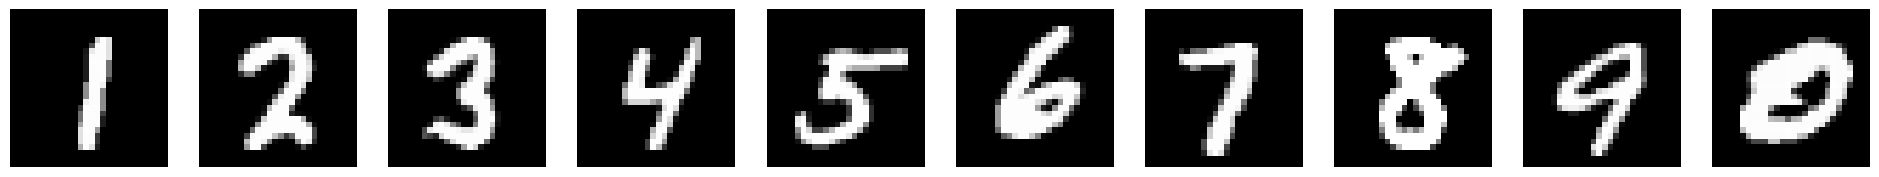

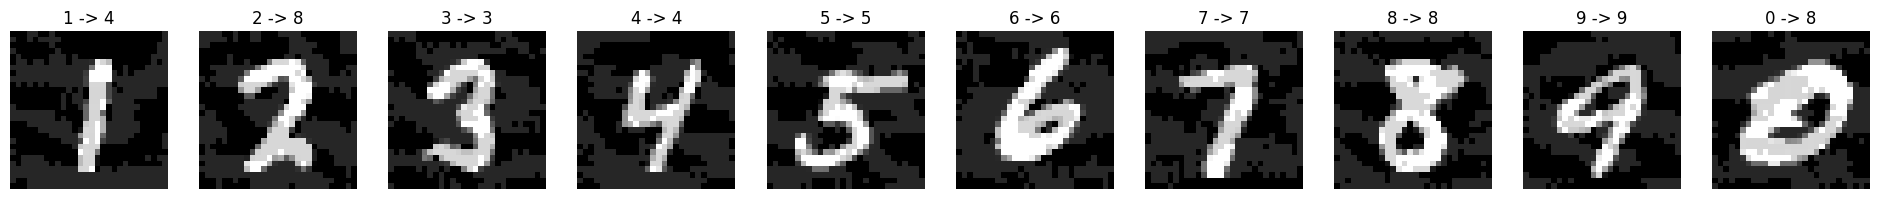

In [ ]:
model.eval()
model_B.eval()

correct = 0
total = 0

correct_B = 0
total_B = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    #generate AEs on model B
    ae_images = fgsm(model_B, criterion, images, labels, step_size=0.15)

    #compute local accuracy on model B
    outputs = model_B(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total_B += labels.size(0)
    correct_B += (predicted == labels).sum().item()

    #compute accuracy on model A
    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct_B / total_B) * 100))

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images_withPred(ae_images[:10].detach(),labels[:10], outputs[:10].argmax(dim=1))

Related materials:
https://colab.research.google.com/drive/1_Bx3HkZ7ZOmSmsSVryfqEMKkKR-q9363?usp=sharing
